In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrinedhi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

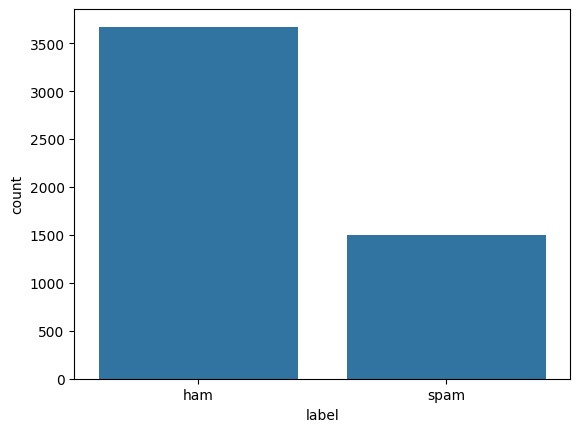

In [5]:
data = pd.read_csv(r'C:\Users\shrinedhi\spam_email\spam_ham_dataset.csv')

data.head()
data.shape
sns.countplot(x='label', data=data)
plt.show()


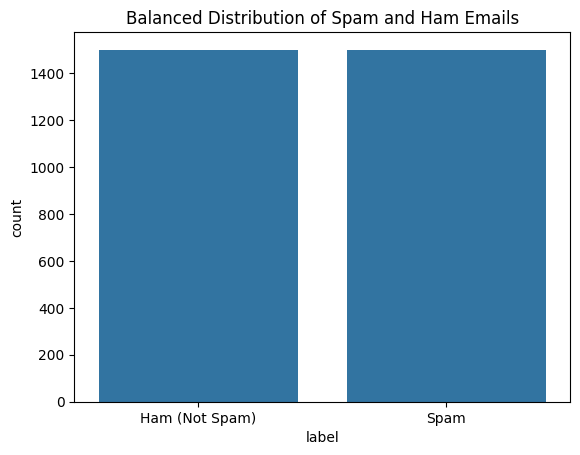

In [6]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()


In [7]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')

def remove_punctuations(text):
    temp = str.maketrans('', '', string.punctuation)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(remove_punctuations)

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(imp_words)

balanced_data['text'] = balanced_data['text'].apply(remove_stopwords)


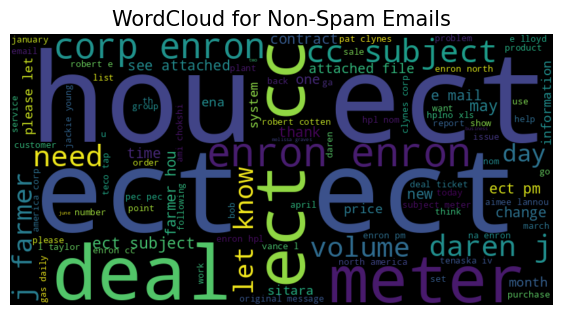

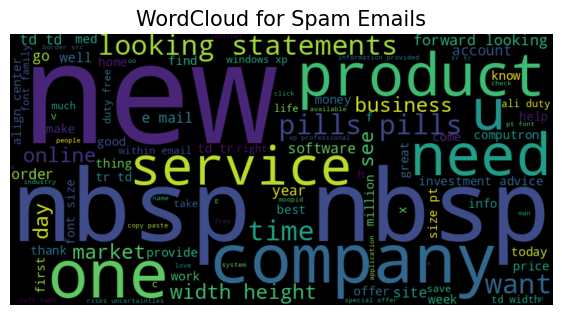

In [8]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')


In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.5190 - loss: 0.6921 - val_accuracy: 0.6233 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8108 - loss: 0.4433 - val_accuracy: 0.9383 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9201 - loss: 0.2506 - val_accuracy: 0.9367 - val_loss: 0.2021 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9518 - loss: 0.1783 - val_accuracy: 0.9500 - val_loss: 0.1938 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9579 - loss: 0.1656 - val_accuracy: 0.9550 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9552 - loss: 0.1825 - val_accuracy: 0.9483 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9360 - loss: 0.2350 - val_ac

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9822 - loss: 0.0800
Test Loss : 0.0818527489900589
Test Accuracy : 0.9816666841506958


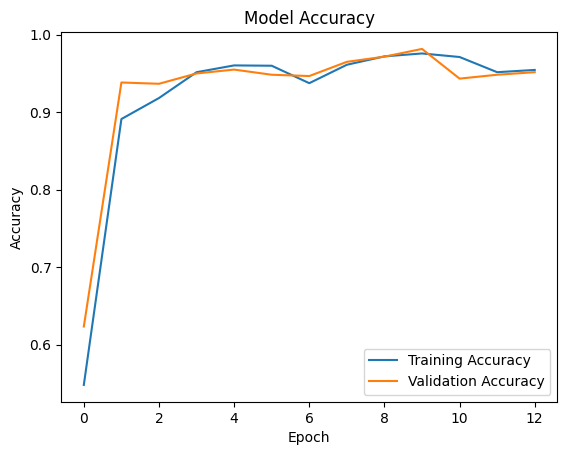

In [12]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :', test_loss)
print('Test Accuracy :', test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
